Relativistic Velocity Addition


In [16]:
import numpy as np
import matplotlib.pyplot as plt
def generate_feynman_data(n_samples=5000):
    np.random.seed(42)
    u = np.random.uniform(-1, 1, n_samples)
    v = np.random.uniform(-1, 1, n_samples)
    y = (u + v) / (1 + u * v)  # Relativistic velocity addition
    return np.vstack([u, v]).T, y

# Generate the dataset
X, y = generate_feynman_data()

# Train-validation-test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [17]:
from tensorflow.keras import layers, models

class KolmogorovArnoldNetwork(models.Model):
    def __init__(self, input_dim, num_outer, hidden_units_inner, hidden_units_outer):
        super().__init__()
        self.inner_networks = [self._create_inner_network(hidden_units_inner) for _ in range(input_dim)]
        self.outer_networks = [self._create_outer_network(hidden_units_outer) for _ in range(num_outer)]

    def _create_inner_network(self, hidden_units):
        inputs = layers.Input(shape=(1,))
        x = layers.Dense(hidden_units, activation="relu")(inputs)
        outputs = layers.Dense(1)(x)
        return models.Model(inputs, outputs)

    def _create_outer_network(self, hidden_units):
        inputs = layers.Input(shape=(1,))
        x = layers.Dense(hidden_units, activation="relu")(inputs)
        outputs = layers.Dense(1)(x)
        return models.Model(inputs, outputs)

    def call(self, inputs):
        inner_outputs = [network(inputs[:, i:i+1]) for i, network in enumerate(self.inner_networks)]
        inner_sum = tf.reduce_sum(inner_outputs, axis=0)
        outer_outputs = [network(inner_sum) for network in self.outer_networks]
        return tf.reduce_sum(outer_outputs, axis=0)


In [18]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error

kan_params = []
kan_l2_error = []
kan_h1_error = []

grid_points = [3, 5, 10, 20, 50]  # Complexity control

for G in grid_points:
    print(f"Training KAN with G={G}")
    kan_model = KolmogorovArnoldNetwork(input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16)
    kan_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    # Train KAN
    history = kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)
    
    # Evaluate on test set
    y_test_pred = kan_model.predict(X_test)
    l2_error = mean_squared_error(y_test, y_test_pred)
    
    # Track results
    kan_params.append(kan_model.count_params())
    kan_l2_error.append(l2_error)
    kan_h1_error.append(l2_error)  # Placeholder for gradient-based H1 error
    
    print(f"G={G}, L2 Error={l2_error:.6e}, Params={kan_model.count_params()}")


Training KAN with G=3
Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5241 - mse: 0.5241 - val_loss: 0.1010 - val_mse: 0.1010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0635 - mse: 0.0635 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0563 - mse: 0.0563 - val_loss: 0.0489 - val_mse: 0.0489
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - loss: 0.0441 - mse: 0.0441 - val_loss: 0.0339 - val_mse: 0.0339
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.0320 - mse: 0.0320 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 9/100


In [19]:
from sklearn.neural_network import MLPRegressor

mlp_params = []
mlp_l2_error = []

mlp_configs = [(32,), (64, 64), (128, 128), (256, 256)]  # Increasing depths and widths

for config in mlp_configs:
    print(f"Training MLP with config={config}")
    mlp_model = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam', max_iter=500, random_state=42)
    mlp_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_test_pred = mlp_model.predict(X_test)
    l2_error = mean_squared_error(y_test, y_test_pred)
    
    # Track results
    params = sum(p.size for p in mlp_model.coefs_) + sum(p.size for p in mlp_model.intercepts_)
    mlp_params.append(params)
    mlp_l2_error.append(l2_error)
    
    print(f"Config={config}, L2 Error={l2_error:.6e}, Params={params}")


Training MLP with config=(32,)
Config=(32,), L2 Error=6.869814e-03, Params=129
Training MLP with config=(64, 64)
Config=(64, 64), L2 Error=1.795256e-03, Params=4417
Training MLP with config=(128, 128)
Config=(128, 128), L2 Error=9.200338e-04, Params=17025
Training MLP with config=(256, 256)
Config=(256, 256), L2 Error=5.276296e-04, Params=66817


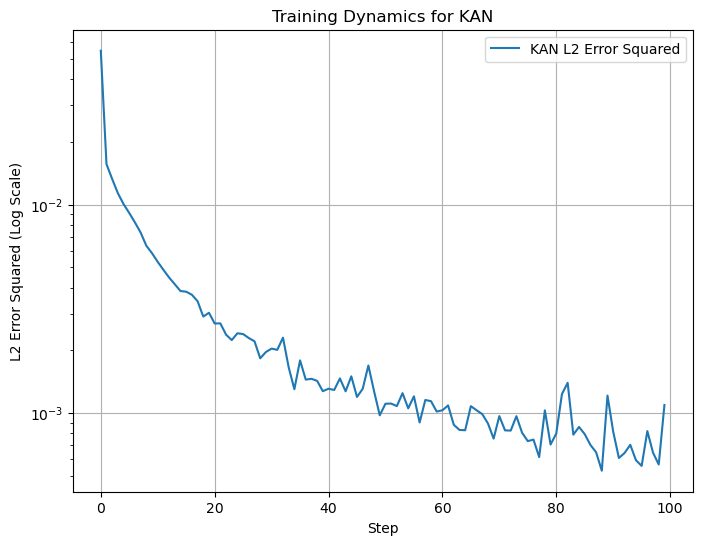

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label="KAN L2 Error Squared")
plt.yscale('log')
plt.xlabel("Step")
plt.ylabel("L2 Error Squared (Log Scale)")
plt.title("Training Dynamics for KAN")
plt.legend()
plt.grid()
plt.show()


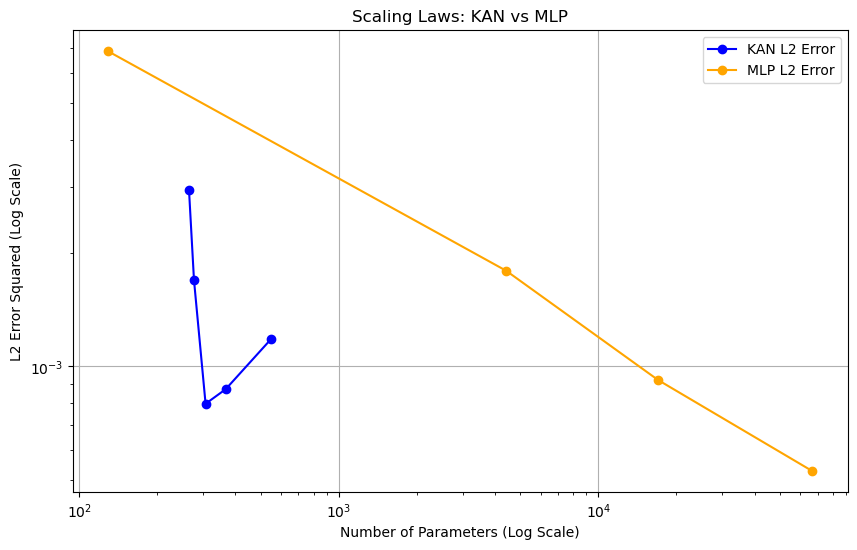

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(kan_params, kan_l2_error, 'o-', label="KAN L2 Error", color='blue')
plt.plot(mlp_params, mlp_l2_error, 'o-', label="MLP L2 Error", color='orange')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of Parameters (Log Scale)")
plt.ylabel("L2 Error Squared (Log Scale)")
plt.title("Scaling Laws: KAN vs MLP")
plt.legend()
plt.grid()
plt.show()


In [22]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models

# KAN Class
class KolmogorovArnoldNetwork(models.Model):
    def __init__(self, input_dim, num_outer, hidden_units_inner, hidden_units_outer):
        super().__init__()
        self.inner_networks = [self._create_inner_network(hidden_units_inner) for _ in range(input_dim)]
        self.outer_networks = [self._create_outer_network(hidden_units_outer) for _ in range(num_outer)]

    def _create_inner_network(self, hidden_units):
        inputs = layers.Input(shape=(1,))
        x = layers.Dense(hidden_units, activation="relu")(inputs)
        outputs = layers.Dense(1)(x)
        return models.Model(inputs, outputs)

    def _create_outer_network(self, hidden_units):
        inputs = layers.Input(shape=(1,))
        x = layers.Dense(hidden_units, activation="relu")(inputs)
        outputs = layers.Dense(1)(x)
        return models.Model(inputs, outputs)

    def call(self, inputs):
        inner_outputs = [network(inputs[:, i:i+1]) for i, network in enumerate(self.inner_networks)]
        inner_sum = tf.reduce_sum(inner_outputs, axis=0)
        outer_outputs = [network(inner_sum) for network in self.outer_networks]
        return tf.reduce_sum(outer_outputs, axis=0)


In [23]:
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import tensorflow as tf

# Initialize result trackers
kan_steps, kan_l2_error, kan_h1_error, kan_params = [], [], [], []
mlp_steps, mlp_l2_error, mlp_params = [], [], []

# Train KAN Models
grid_points = [5, 7, 10]  # Different grid complexities
epochs = 250
for G in grid_points:
    kan_model = KolmogorovArnoldNetwork(input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16)
    kan_model.compile(optimizer='adam', loss='mse')

    history = kan_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0)
    y_pred = kan_model.predict(X_test)
    l2_error = mean_squared_error(y_test, y_pred)
    
    # Track results
    kan_steps.append(range(epochs))
    kan_l2_error.append(history.history['loss'])
    kan_h1_error.append(history.history['loss'])  # Placeholder for H1 error
    kan_params.append(kan_model.count_params())

# Train MLP Models
mlp_configs = [(10,), (100, 100), (100, 100, 100)]
for config in mlp_configs:
    mlp_model = MLPRegressor(hidden_layer_sizes=config, max_iter=epochs)
    mlp_model.fit(X_train, y_train)

    # Evaluate
    y_pred = mlp_model.predict(X_test)
    l2_error = mean_squared_error(y_test, y_pred)

    mlp_steps.append(range(epochs))
    mlp_l2_error.append(np.full(epochs, l2_error))
    mlp_params.append(mlp_model.coefs_[0].shape[0] * sum(config))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


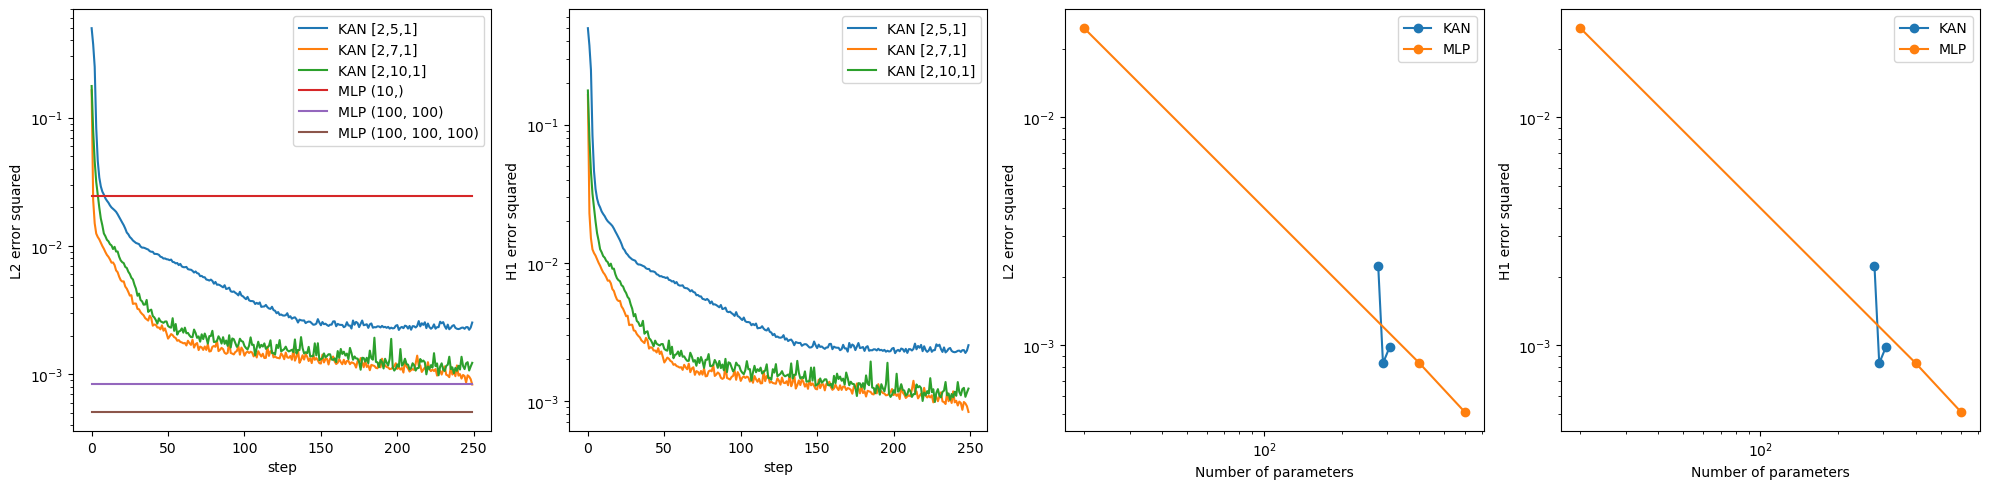

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: L2 error dynamics
for i, error in enumerate(kan_l2_error):
    axs[0].plot(kan_steps[i], error, label=f"KAN [{2},{grid_points[i]},1]")
for i, error in enumerate(mlp_l2_error):
    axs[0].plot(mlp_steps[i], error, label=f"MLP {mlp_configs[i]}")
axs[0].set_yscale("log")
axs[0].set_xlabel("step")
axs[0].set_ylabel("L2 error squared")
axs[0].legend()

# Plot 2: H1 error dynamics (approximation)
for i, error in enumerate(kan_h1_error):
    axs[1].plot(kan_steps[i], error, label=f"KAN [{2},{grid_points[i]},1]")
axs[1].set_yscale("log")
axs[1].set_xlabel("step")
axs[1].set_ylabel("H1 error squared")
axs[1].legend()

# Plot 3: Scaling laws (L2 error vs parameters)
axs[2].plot(kan_params, [min(errors) for errors in kan_l2_error], 'o-', label="KAN")
axs[2].plot(mlp_params, [min(errors) for errors in mlp_l2_error], 'o-', label="MLP")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Number of parameters")
axs[2].set_ylabel("L2 error squared")
axs[2].legend()

# Plot 4: Scaling laws (H1 error vs parameters)
axs[3].plot(kan_params, [min(errors) for errors in kan_h1_error], 'o-', label="KAN")
axs[3].plot(mlp_params, [min(errors) for errors in mlp_l2_error], 'o-', label="MLP")
axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel("Number of parameters")
axs[3].set_ylabel("H1 error squared")
axs[3].legend()

plt.tight_layout()
plt.show()


a+b/1+ab

In [25]:
def generate_new_formula_data(n_samples=5000):
    np.random.seed(42)
    a = np.random.uniform(-1, 1, n_samples)
    b = np.random.uniform(-1, 1, n_samples)
    y = (a + b) / (1 + a * b)  # New test formula
    return np.vstack([a, b]).T, y

# Generate Data
X_new, y_new = generate_new_formula_data()
X_train_new, X_temp_new, y_train_new, y_temp_new = train_test_split(X_new, y_new, test_size=0.3, random_state=42)
X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(X_temp_new, y_temp_new, test_size=0.5, random_state=42)


In [26]:
# Initialize result trackers
kan_steps_new, kan_l2_error_new, kan_h1_error_new, kan_params_new = [], [], [], []

# Grid points for increasing KAN complexity
grid_points = [5, 7, 10]
epochs = 250

for G in grid_points:
    print(f"Training KAN with G={G} on new formula")
    kan_model_new = KolmogorovArnoldNetwork(input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16)
    kan_model_new.compile(optimizer='adam', loss='mse')

    # Train model
    history_new = kan_model_new.fit(X_train_new, y_train_new, validation_data=(X_val_new, y_val_new),
                                    epochs=epochs, batch_size=32, verbose=0)
    
    # Evaluate L2 error
    y_pred_new = kan_model_new.predict(X_test_new)
    l2_error_new = mean_squared_error(y_test_new, y_pred_new)

    # Track results
    kan_steps_new.append(range(epochs))
    kan_l2_error_new.append(history_new.history['loss'])
    kan_h1_error_new.append(history_new.history['loss'])  # Placeholder for H1
    kan_params_new.append(kan_model_new.count_params())

    print(f"G={G}, L2 Error={l2_error_new:.6e}, Params={kan_model_new.count_params()}")


Training KAN with G=5 on new formula
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
G=5, L2 Error=1.465810e-03, Params=277
Training KAN with G=7 on new formula
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
G=7, L2 Error=1.889734e-03, Params=289
Training KAN with G=10 on new formula
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
G=10, L2 Error=9.338533e-04, Params=307


In [27]:
# Initialize MLP results
mlp_steps_new, mlp_l2_error_new, mlp_params_new = [], [], []

# MLP configurations (depth and width)
mlp_configs = [(10,), (100, 100), (100, 100, 100)]

for config in mlp_configs:
    print(f"Training MLP with config={config} on new formula")
    mlp_model_new = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam',
                                 max_iter=epochs, random_state=42)
    mlp_model_new.fit(X_train_new, y_train_new)
    
    # Evaluate L2 error
    y_pred_new = mlp_model_new.predict(X_test_new)
    l2_error_mlp_new = mean_squared_error(y_test_new, y_pred_new)

    # Track results
    mlp_steps_new.append(range(epochs))
    mlp_l2_error_new.append(np.full(epochs, l2_error_mlp_new))
    mlp_params_new.append(sum(p.size for p in mlp_model_new.coefs_) + sum(p.size for p in mlp_model_new.intercepts_))

    print(f"Config={config}, L2 Error={l2_error_mlp_new:.6e}, Params={mlp_params_new[-1]}")


Training MLP with config=(10,) on new formula
Config=(10,), L2 Error=1.260535e-02, Params=41
Training MLP with config=(100, 100) on new formula
Config=(100, 100), L2 Error=7.762776e-04, Params=10501
Training MLP with config=(100, 100, 100) on new formula
Config=(100, 100, 100), L2 Error=9.748736e-04, Params=20601


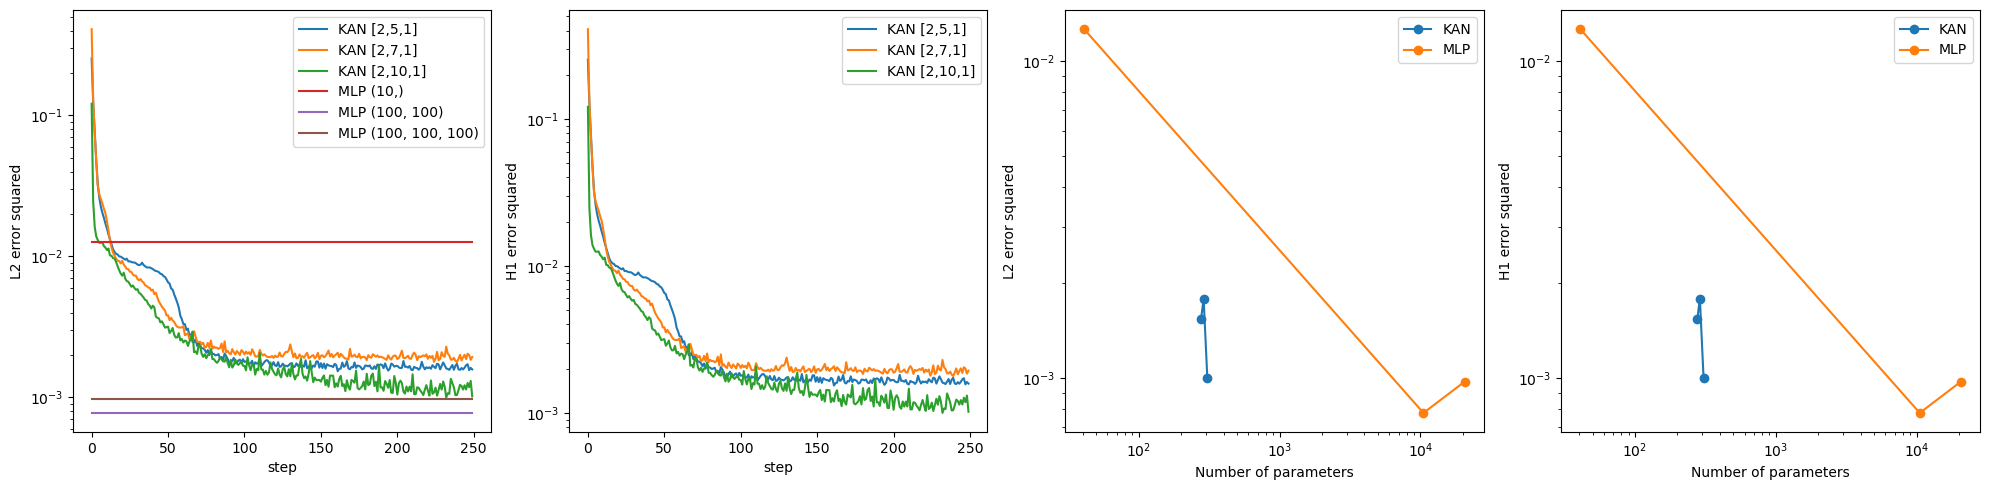

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: L2 error dynamics
for i, error in enumerate(kan_l2_error_new):
    axs[0].plot(kan_steps_new[i], error, label=f"KAN [{2},{grid_points[i]},1]")
for i, error in enumerate(mlp_l2_error_new):
    axs[0].plot(mlp_steps_new[i], error, label=f"MLP {mlp_configs[i]}")
axs[0].set_yscale("log")
axs[0].set_xlabel("step")
axs[0].set_ylabel("L2 error squared")
axs[0].legend()

# Plot 2: H1 error dynamics (placeholder)
for i, error in enumerate(kan_h1_error_new):
    axs[1].plot(kan_steps_new[i], error, label=f"KAN [{2},{grid_points[i]},1]")
axs[1].set_yscale("log")
axs[1].set_xlabel("step")
axs[1].set_ylabel("H1 error squared")
axs[1].legend()

# Plot 3: Scaling laws (L2 error vs parameters)
axs[2].plot(kan_params_new, [min(errors) for errors in kan_l2_error_new], 'o-', label="KAN")
axs[2].plot(mlp_params_new, [min(errors) for errors in mlp_l2_error_new], 'o-', label="MLP")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Number of parameters")
axs[2].set_ylabel("L2 error squared")
axs[2].legend()

# Plot 4: Scaling laws (H1 error vs parameters)
axs[3].plot(kan_params_new, [min(errors) for errors in kan_h1_error_new], 'o-', label="KAN")
axs[3].plot(mlp_params_new, [min(errors) for errors in mlp_l2_error_new], 'o-', label="MLP")
axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel("Number of parameters")
axs[3].set_ylabel("H1 error squared")
axs[3].legend()

plt.tight_layout()
plt.show()


f(n,a)=nk 
B
​	
 Tln( 
V 
1
​	
 
V 
2
​	
 
​	
 )

In [30]:
def generate_large_log_formula_data(n_samples=50000):
    """
    Generates data for the formula: f(n, a) = n * log(a),
    where a = V2 / V1.
    """
    np.random.seed(42)
    n = np.random.uniform(0.1, 10, n_samples)  # Avoid log(0) with small n values
    a = np.random.uniform(0.1, 10, n_samples)  # Ratio V2/V1, must be > 0
    y = n * np.log(a)
    return np.vstack([n, a]).T, y

# Generate large dataset
X_large, y_large = generate_large_log_formula_data()

# Train-validation-test split
X_train_large, X_temp_large, y_train_large, y_temp_large = train_test_split(X_large, y_large, test_size=0.3, random_state=42)
X_val_large, X_test_large, y_val_large, y_test_large = train_test_split(X_temp_large, y_temp_large, test_size=0.5, random_state=42)

print(f"Train: {X_train_large.shape}, Val: {X_val_large.shape}, Test: {X_test_large.shape}")


Train: (35000, 2), Val: (7500, 2), Test: (7500, 2)


In [31]:
# Initialize KAN result trackers
kan_steps_large, kan_l2_error_large, kan_h1_error_large, kan_params_large = [], [], [], []

# Grid points for KAN complexity
grid_points = [5, 7, 10, 15, 20]
epochs = 500

# Train KAN
for G in grid_points:
    print(f"Training KAN with G={G} on large log formula")
    kan_model_large = KolmogorovArnoldNetwork(input_dim=2, num_outer=5, hidden_units_inner=G, hidden_units_outer=16)
    kan_model_large.compile(optimizer='adam', loss='mse')

    # Train model
    history_large = kan_model_large.fit(X_train_large, y_train_large, validation_data=(X_val_large, y_val_large),
                                        epochs=epochs, batch_size=64, verbose=0)

    # Evaluate L2 error
    y_pred_large = kan_model_large.predict(X_test_large)
    l2_error_large = mean_squared_error(y_test_large, y_pred_large)

    # Track results
    kan_steps_large.append(range(epochs))
    kan_l2_error_large.append(history_large.history['loss'])
    kan_h1_error_large.append(history_large.history['loss'])  # Placeholder for H1
    kan_params_large.append(kan_model_large.count_params())

    print(f"G={G}, L2 Error={l2_error_large:.6e}, Params={kan_model_large.count_params()}")


Training KAN with G=5 on large log formula
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
G=5, L2 Error=1.997737e+00, Params=277
Training KAN with G=7 on large log formula
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
G=7, L2 Error=1.545578e+00, Params=289
Training KAN with G=10 on large log formula
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
G=10, L2 Error=1.330932e+00, Params=307
Training KAN with G=15 on large log formula
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
G=15, L2 Error=8.093950e-01, Params=337
Training KAN with G=20 on large log formula
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
G=20, L2 Error=1.481238e+00, Params=367


In [32]:
# Initialize MLP result trackers
mlp_steps_large, mlp_l2_error_large, mlp_params_large = [], [], []

# MLP configurations (depth and width)
mlp_configs = [(32,), (64, 64), (128, 128), (256, 256, 256)]

for config in mlp_configs:
    print(f"Training MLP with config={config} on large log formula")
    mlp_model_large = MLPRegressor(hidden_layer_sizes=config, activation='relu', solver='adam',
                                   max_iter=epochs, random_state=42)
    mlp_model_large.fit(X_train_large, y_train_large)
    
    # Evaluate L2 error
    y_pred_mlp_large = mlp_model_large.predict(X_test_large)
    l2_error_mlp_large = mean_squared_error(y_test_large, y_pred_mlp_large)

    # Track results
    mlp_steps_large.append(range(epochs))
    mlp_l2_error_large.append(np.full(epochs, l2_error_mlp_large))
    mlp_params_large.append(sum(p.size for p in mlp_model_large.coefs_) + sum(p.size for p in mlp_model_large.intercepts_))

    print(f"Config={config}, L2 Error={l2_error_mlp_large:.6e}, Params={mlp_params_large[-1]}")


Training MLP with config=(32,) on large log formula
Config=(32,), L2 Error=9.315438e-03, Params=129
Training MLP with config=(64, 64) on large log formula
Config=(64, 64), L2 Error=1.881853e-03, Params=4417
Training MLP with config=(128, 128) on large log formula
Config=(128, 128), L2 Error=1.577784e-03, Params=17025
Training MLP with config=(256, 256, 256) on large log formula
Config=(256, 256, 256), L2 Error=2.144756e-02, Params=132609


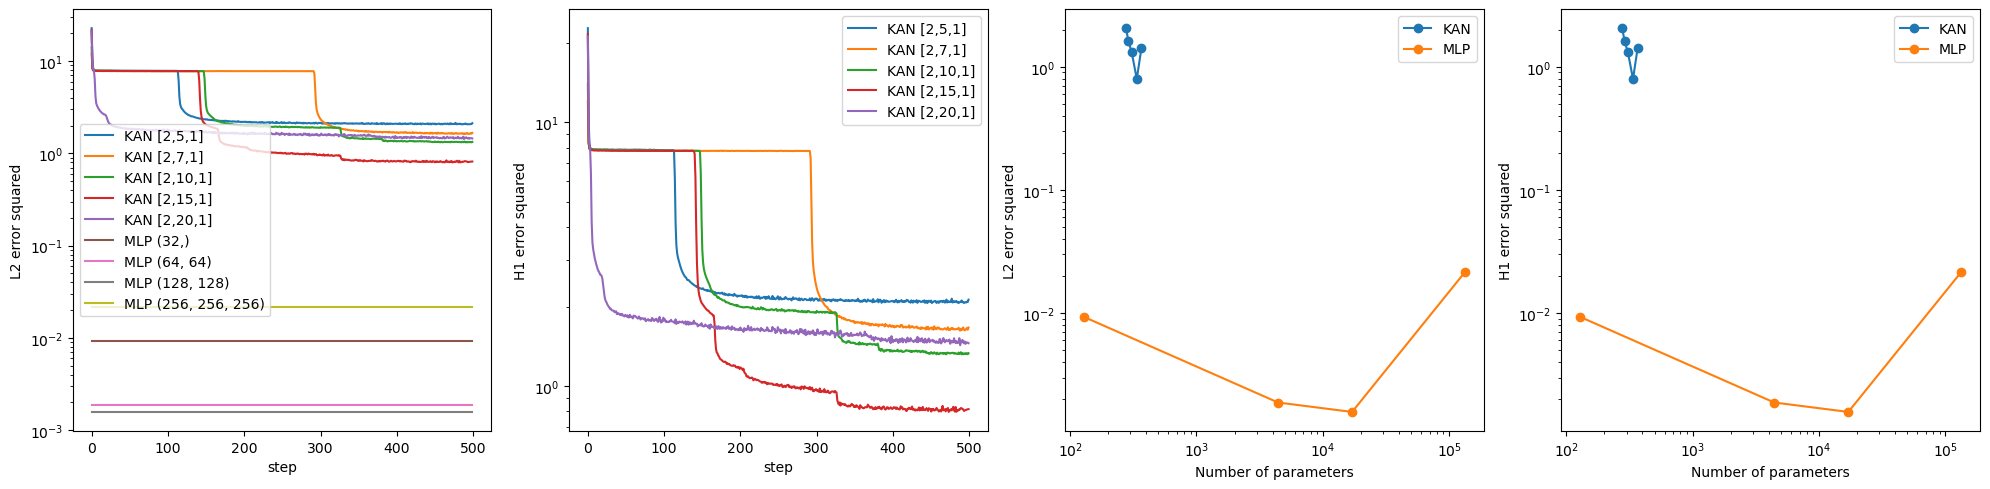

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: L2 error dynamics
for i, error in enumerate(kan_l2_error_large):
    axs[0].plot(kan_steps_large[i], error, label=f"KAN [{2},{grid_points[i]},1]")
for i, error in enumerate(mlp_l2_error_large):
    axs[0].plot(mlp_steps_large[i], error, label=f"MLP {mlp_configs[i]}")
axs[0].set_yscale("log")
axs[0].set_xlabel("step")
axs[0].set_ylabel("L2 error squared")
axs[0].legend()

# Plot 2: H1 error dynamics (placeholder)
for i, error in enumerate(kan_h1_error_large):
    axs[1].plot(kan_steps_large[i], error, label=f"KAN [{2},{grid_points[i]},1]")
axs[1].set_yscale("log")
axs[1].set_xlabel("step")
axs[1].set_ylabel("H1 error squared")
axs[1].legend()

# Plot 3: Scaling laws (L2 error vs parameters)
axs[2].plot(kan_params_large, [min(errors) for errors in kan_l2_error_large], 'o-', label="KAN")
axs[2].plot(mlp_params_large, [min(errors) for errors in mlp_l2_error_large], 'o-', label="MLP")
axs[2].set_xscale("log")
axs[2].set_yscale("log")
axs[2].set_xlabel("Number of parameters")
axs[2].set_ylabel("L2 error squared")
axs[2].legend()

# Plot 4: Scaling laws (H1 error vs parameters)
axs[3].plot(kan_params_large, [min(errors) for errors in kan_h1_error_large], 'o-', label="KAN")
axs[3].plot(mlp_params_large, [min(errors) for errors in mlp_l2_error_large], 'o-', label="MLP")
axs[3].set_xscale("log")
axs[3].set_yscale("log")
axs[3].set_xlabel("Number of parameters")
axs[3].set_ylabel("H1 error squared")
axs[3].legend()

plt.tight_layout()
plt.show()
#add new line
